label_classes is {'ST': 0, 'DT': 1, 'P': 2, 'G': 3, 'NC': 4}
label_map is {'ST': 0, 'DT': 1, 'P': 2, 'G': 3, 'NC': 4}
y_encoded is [4 4 4 ... 3 3 3]


/Users/shangyu/anaconda3/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'n_neighbors': 1, 'weights': 'uniform'}
Accuracy: 0.95
Predicted labels: [2 1 3 ... 2 3 2]
True labels: [2 1 3 ... 2 3 2]
              precision    recall  f1-score   support

          ST       0.81      0.75      0.78       157
          DT       0.88      0.76      0.82       228
           P       1.00      0.98      0.99       486
           G       0.98      0.95      0.96       465
          NC       0.95      1.00      0.98      1286

    accuracy                           0.95      2622
   macro avg       0.93      0.89      0.91      2622
weighted avg       0.95      0.95      0.95      2622



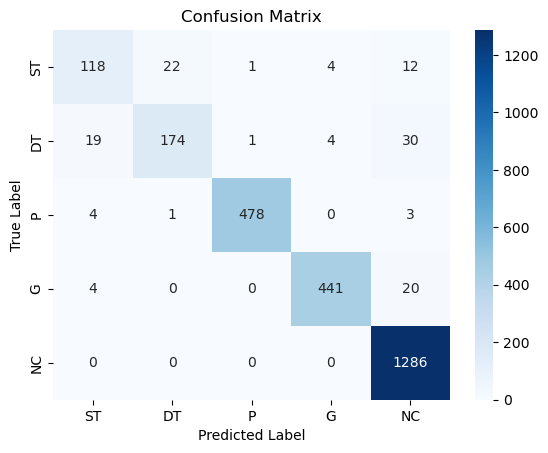

In [1]:
#knn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter



# Load data
data_path = '../DATA/labeled_window_dataset.csv'
df = pd.read_csv(data_path)

# Compute e_q and e_dq for q_d and q, dq_d and dq respectively
e = np.array(df[['q_d0', 'q_d1', 'q_d2', 'q_d3', 'q_d4', 'q_d5','q_d6']]) - np.array(df[['q0', 'q1', 'q2', 'q3', 'q4', 'q5','q6']])
de = np.array(df[['dq_d0', 'dq_d1', 'dq_d2', 'dq_d3', 'dq_d4', 'dq_d5','dq_d6']]) - np.array(df[['dq0', 'dq1', 'dq2', 'dq3', 'dq4', 'dq5','dq6']])

# Combine all required features into a single DataFrame
# tau_J and tau_ext are assumed to be columns in df, each containing 6 subcolumns (tau_J0 - tau_J5, tau_ext0 - tau_ext5)
tau_J = np.array(df[['tau_J0', 'tau_J1', 'tau_J2', 'tau_J3', 'tau_J4', 'tau_J5', 'tau_J6']])
tau_ext = np.array(df[['tau_ext0', 'tau_ext1', 'tau_ext2', 'tau_ext3', 'tau_ext4', 'tau_ext5', 'tau_ext6']])



 # Define columns corresponding to each joint
joint_columns = {
    0: ['e0', 'de0', 'tau_J0', 'tau_ext0'],
    1: ['e1', 'de1', 'tau_J1', 'tau_ext1'],
    2: ['e2', 'de2', 'tau_J2', 'tau_ext2'],
    3: ['e3', 'de3', 'tau_J3', 'tau_ext3'],
    4: ['e4', 'de4', 'tau_J4', 'tau_ext4'],
    5: ['e5', 'de5', 'tau_J5', 'tau_ext5'],
    6: ['e6', 'de6', 'tau_J6', 'tau_ext6'],
}

# Initialize feature and label lists
X_list = []
y_list = []

# Group data by 'block_id'
grouped = df.groupby('window_id')


# Process each group
for window_id, group in grouped:
   
    # print(f"group is {group}")
    # Initialize an empty list to hold the features for this block
    window_features = []
    
    # Concatenate data for each joint
    for joint, cols in joint_columns.items():
        # print(f"joint is {joint}")
        # print(f"cols is {cols}")
        joint_data = group.loc[:, cols].values.flatten()  
        window_features.extend(joint_data)  
        
    X_list.append(window_features)
    # print(f"X_list is {X_list}")
    y_list.append(group['window_touch_type'].iloc[0])  


# Convert lists to numpy arrays
X = np.array(X_list)
# print(f"X is {X} and length is {len(X)}")
y = np.array(y_list)
# print(f"y is {y} and length is {len(y)}") 
 
# Encode labels
label_classes = { 0:"NC",1:"ST", 2:"DT", 3:"P", 4:"G"}
# print(f"label_classes is {label_classes}")
label_map = {key:value for key, value in label_classes.items()}
# print(f"label_map is {label_map}")
y_encoded = np.array([label_map[key] for key in y])
# print(f"y_encoded is {y_encoded}")

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)


# Initialize KNN classifier
knn = KNeighborsClassifier()

# Define hyperparameters grid
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')


# Train KNN classifier with the best parameters
best_knn = grid_search.best_estimator_

# Perform cross-validation on the training set
cv_scores = cross_val_score(best_knn, X_train, y_train, cv=5)

# Predict
y_pred = best_knn.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print predicted and true labels
print(f'Predicted labels: {y_pred}')
print(f'True labels: {y_test}')

# Display classification report
print(classification_report(y_test, y_pred, target_names=label_classes))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_classes, yticklabels=label_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()   